In [70]:
!pip install -q qiskit

In [71]:
!pip install -q qiskit-aer

## 1. A Simple Pauli Noise Model

In [72]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_circuit_layout
from qiskit.quantum_info import Pauli

In [73]:
def add_pauli_noise(circuit, prob_x, prob_z):
    """
    Correctly adds a Pauli noise channel to a circuit with multiple registers.

    Args:
        circuit (QuantumCircuit): The input circuit.
        prob_x (float): The probability of an X error.
        prob_z (float): The probability of a Z error.

    Returns:
        QuantumCircuit: A new circuit with noise added after each gate.
    """
    prob_i = 1 - prob_x - prob_z
    if prob_i < 0:
        raise ValueError("Probabilities must sum to <= 1.")

    noise_circuit = QuantumCircuit(*circuit.qregs, *circuit.cregs)

    # Iterate through instructions
    for instruction in circuit.data:
        noise_circuit.append(instruction)

        # Add noise after the gate, but not after barriers or measurements
        if instruction.operation.name not in ['barrier', 'measure']:
            for qubit in instruction.qubits:
                rand = np.random.random()
                if rand < prob_x:
                    noise_circuit.x(qubit)
                elif rand < prob_x + prob_z:
                    noise_circuit.z(qubit)
    return noise_circuit

Now, we test our noise model

In [74]:
# Making the ideal and noisy circuits
qc_ideal = QuantumCircuit(2, 2)
qc_ideal.h(0)
qc_ideal.cx(0, 1)
qc_ideal.measure([0, 1], [0, 1])
p_x = 0.35
p_z = 0.25
qc_noisy = add_pauli_noise(qc_ideal, p_x, p_z)

In [75]:
# Simulating the ciruits
simulator = AerSimulator()
shots = 2048

t_qc_ideal = transpile(qc_ideal, simulator)
result_ideal = simulator.run(t_qc_ideal, shots=shots).result()
counts_ideal = result_ideal.get_counts()

t_qc_noisy = transpile(qc_noisy, simulator)
result_noisy = simulator.run(t_qc_noisy, shots=shots).result()
counts_noisy = result_noisy.get_counts()

In [76]:
# The Outputs
print("Ideal Circuit Results")
print(counts_ideal, end = "\n\n")
print("Noisy Circuit Results")
print(counts_noisy)

Ideal Circuit Results
{'11': 1045, '00': 1003}

Noisy Circuit Results
{'10': 1026, '01': 1022}


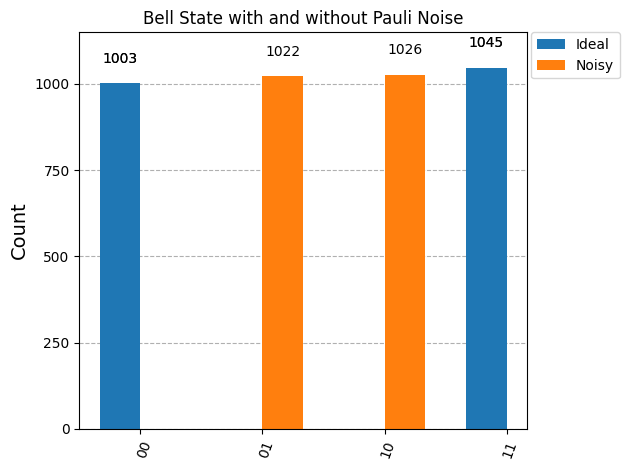

In [77]:
# Visualize the difference
plot_histogram([counts_ideal, counts_noisy], legend=['Ideal', 'Noisy'], title="Bell State with and without Pauli Noise")

## 2. Quantum Repetition Code

It encodes one logical qubit into three physical qubits to protect against a single bit-flip (X) error.

1. **Encoding**

A general state $∣\psi\rangle=\alpha∣0\rangle+\beta∣1\rangle$ is encoded as ∣$\psi\rangle_L​=\alpha∣000\rangle+\beta∣111\rangle$.

This is achieved with a simple circuit using two CNOT gates.

2. **Error Detection**

If a bit-flip occurs on one qubit (e.g., $∣000\rangle \rightarrow ∣100\rangle$), the state is no longer in the valid codespace. We cannot simply measure the three qubits to see which one flipped, as that would destroy the quantum superposition.


So we need to detect the bit flips indirectly. This is done by measuring the parity between pairs of qubits. These parity checks are called **stabilizer measurements**, and their results form the **syndrome**.

For the repetition code, two stabilizers are measured:
1. Parity of Qubit 0 and Qubit 1 ($Z_0​Z_1$​): Are the states of the first two qubits the same or different?
2. Parity of Qubit 1 and Qubit 2 ($Z_1​Z_2$​): Are the states of the last two qubits the same or different?

The measurement results give us a two-bit syndrome that uniquely identifies the error. This measurement is done by using two extra ancilla qubits. CNOT gates are used to copy the parity information onto the ancillas, which are then measured. This extracts the syndrome without disturbing the main data qubits.

In [78]:
# Initializing Registers
logical_qubit_index = 0
qr = QuantumRegister(3, name='data')
ar = QuantumRegister(2, name='syndrome')
cr = ClassicalRegister(3, name='c_data')
sc = ClassicalRegister(2, name='c_syndrome')

In [79]:
# Preparing initial state |+>
qc_rep = QuantumCircuit(qr, ar, cr, sc)
qc_rep.h(logical_qubit_index)

qc_rep.cx(qr[0], qr[1])
qc_rep.cx(qr[0], qr[2])
qc_rep.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=5, num_clbits=0, params=[]), qubits=(<Qubit register=(3, "data"), index=0>, <Qubit register=(3, "data"), index=1>, <Qubit register=(3, "data"), index=2>, <Qubit register=(2, "syndrome"), index=0>, <Qubit register=(2, "syndrome"), index=1>), clbits=())

In [80]:
# inserting X error
qc_rep.x(qr[1])
qc_rep.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=5, num_clbits=0, params=[]), qubits=(<Qubit register=(3, "data"), index=0>, <Qubit register=(3, "data"), index=1>, <Qubit register=(3, "data"), index=2>, <Qubit register=(2, "syndrome"), index=0>, <Qubit register=(2, "syndrome"), index=1>), clbits=())

In [81]:
# Measure stabilizers Z_0Z_1 and Z_1Z_2
qc_rep.cx(qr[0], ar[0])
qc_rep.cx(qr[1], ar[0])
qc_rep.cx(qr[1], ar[1])
qc_rep.cx(qr[2], ar[1])
qc_rep.measure(ar, sc)
qc_rep.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=5, num_clbits=0, params=[]), qubits=(<Qubit register=(3, "data"), index=0>, <Qubit register=(3, "data"), index=1>, <Qubit register=(3, "data"), index=2>, <Qubit register=(2, "syndrome"), index=0>, <Qubit register=(2, "syndrome"), index=1>), clbits=())

In [82]:
# Apply correction based on syndrome measurement
'''
Syndrome '10' implies error on qubit 0
Syndrome '11' implies error on qubit 1
Syndrome '01' implies error on qubit 2
'''
with qc_rep.if_test((sc, 1)): # sc == '01'
    qc_rep.x(qr[2])
with qc_rep.if_test((sc, 2)): # sc == '10'
    qc_rep.x(qr[0])
with qc_rep.if_test((sc, 3)): # sc == '11'
    qc_rep.x(qr[1])
qc_rep.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=5, num_clbits=0, params=[]), qubits=(<Qubit register=(3, "data"), index=0>, <Qubit register=(3, "data"), index=1>, <Qubit register=(3, "data"), index=2>, <Qubit register=(2, "syndrome"), index=0>, <Qubit register=(2, "syndrome"), index=1>), clbits=())

In [83]:
# Decoding and Measurement
qc_rep.cx(qr[0], qr[2])
qc_rep.cx(qr[0], qr[1])
qc_rep.h(qr[0])
qc_rep.measure(qr[0], cr[0])


--- Repetition Code Test Results ---
{'11 000': 2048}


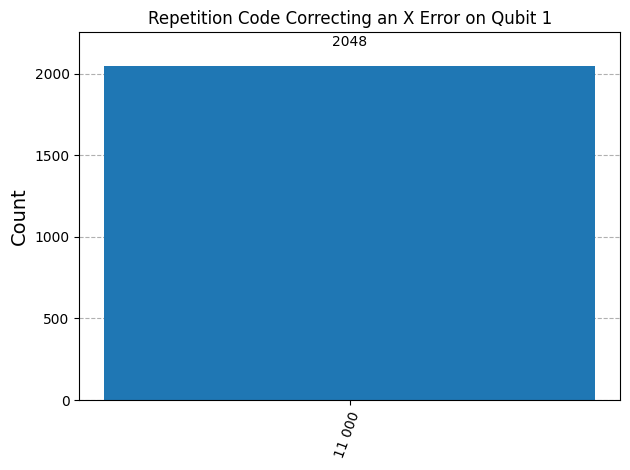

In [84]:
# Simulation
t_qc_rep = transpile(qc_rep, simulator)
result = simulator.run(t_qc_rep, shots=shots).result()
counts = result.get_counts()
print("\n--- Repetition Code Test Results ---")
print(counts)
plot_histogram(counts, title="Repetition Code Correcting an X Error on Qubit 1")

The results show that even with a guaranteed X error on the second qubit, the correction logic successfully flips it back, and we predominantly measure the correct logical state.

### Why does the Repetition Code fail for Z errors?
The failure of Repetition Code for Z errors can be explained via 2 reasons:
1. **State Invariance:** A Z error on any qubit maps the logical state $∣\psi\rangle_L​=\alpha∣000\rangle+\beta∣111\rangle$ to $\alpha∣000\rangle−\beta∣111\rangle$. This new state is still a valid superposition of the two basis states ∣000⟩ and ∣111⟩. The relative phase has changed, but the computational basis measurements are unaffected.
2. **Syndrome Invisibility:** The stabilizers ($Z_0​Z_1​, Z_1​Z_2$​) are composed of Z operators. All Pauli Z operators commute with each other. Therefore, a Z error on any data qubit will commute with the stabilizer measurements. The stabilizers will always measure +1 (syndrome 00), making the Z error completely undetectable.

To fix phase errors, we need to encode the state in Hadamard basis, which swaps the roles of X and Z errors. The Shor code combines both approaches.

# 3. Shor code

The Shor code is a concatenated code that combines a phase-flip and a bit-flip correction code to correct any arbitrary single-qubit error. 9 physical qubits encode 1 logical qubit and can correct errors on any single qubit.
1. **Phase-Flip Correction:** A single logical qubit is encoded into three qubits to protect against phase-flips
2. **Bit-Flip Correction:** Each of those three qubits is then encoded into its own block of three physical qubits to protect against bit-flips.

In [85]:
# Define Registers
q = QuantumRegister(9, name='data')
a = QuantumRegister(2, name='ancilla')
c_syn = ClassicalRegister(8, name='syndrome')
c_out = ClassicalRegister(1, name='output')

In [86]:
# Create the main circuit
qc_shor = QuantumCircuit(q, a, c_syn, c_out)

### 1. Encoding


In [87]:
# Build the encoder circuit
encoder = QuantumCircuit(q, name='Encoder')
encoder.h(q[0])
encoder.cx(q[0], q[3]); encoder.cx(q[0], q[6])
encoder.h(q[0]); encoder.h(q[3]); encoder.h(q[6])
encoder.cx(q[0], q[1]); encoder.cx(q[0], q[2])
encoder.cx(q[3], q[4]); encoder.cx(q[3], q[5])
encoder.cx(q[6], q[7]); encoder.cx(q[6], q[8])
qc_shor.append(encoder, q)
qc_shor.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=11, num_clbits=0, params=[]), qubits=(<Qubit register=(9, "data"), index=0>, <Qubit register=(9, "data"), index=1>, <Qubit register=(9, "data"), index=2>, <Qubit register=(9, "data"), index=3>, <Qubit register=(9, "data"), index=4>, <Qubit register=(9, "data"), index=5>, <Qubit register=(9, "data"), index=6>, <Qubit register=(9, "data"), index=7>, <Qubit register=(9, "data"), index=8>, <Qubit register=(2, "ancilla"), index=0>, <Qubit register=(2, "ancilla"), index=1>), clbits=())

### 2. Noisy Channel
We apply a noise model with a 10% chance of an X error and 10% for a Z error on all 9 data qubits.

In [88]:
qc_shor = add_pauli_noise(qc_shor, prob_x=0.1, prob_z=0.1)
qc_shor.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=11, num_clbits=0, params=[]), qubits=(<Qubit register=(9, "data"), index=0>, <Qubit register=(9, "data"), index=1>, <Qubit register=(9, "data"), index=2>, <Qubit register=(9, "data"), index=3>, <Qubit register=(9, "data"), index=4>, <Qubit register=(9, "data"), index=5>, <Qubit register=(9, "data"), index=6>, <Qubit register=(9, "data"), index=7>, <Qubit register=(9, "data"), index=8>, <Qubit register=(2, "ancilla"), index=0>, <Qubit register=(2, "ancilla"), index=1>), clbits=())

### 3. Syndrome Detection and Correction

In [89]:
# a) Bit-flip correction

for i in range(3):
    block_start = i * 3
    syndrome_bits = [c_syn[2*i], c_syn[2*i+1]]
    qc_shor.cx(q[block_start], a[0]); qc_shor.cx(q[block_start + 1], a[0])
    qc_shor.cx(q[block_start + 1], a[1]); qc_shor.cx(q[block_start + 2], a[1])
    qc_shor.measure(a, syndrome_bits)
    val_1 = 1 << (2*i); val_2 = 2 << (2*i); val_3 = 3 << (2*i)
    with qc_shor.if_test((c_syn, val_1)): qc_shor.x(q[block_start + 2])
    with qc_shor.if_test((c_syn, val_2)): qc_shor.x(q[block_start])
    with qc_shor.if_test((c_syn, val_3)): qc_shor.x(q[block_start + 1])
    qc_shor.reset(a)
qc_shor.barrier()


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=11, num_clbits=0, params=[]), qubits=(<Qubit register=(9, "data"), index=0>, <Qubit register=(9, "data"), index=1>, <Qubit register=(9, "data"), index=2>, <Qubit register=(9, "data"), index=3>, <Qubit register=(9, "data"), index=4>, <Qubit register=(9, "data"), index=5>, <Qubit register=(9, "data"), index=6>, <Qubit register=(9, "data"), index=7>, <Qubit register=(9, "data"), index=8>, <Qubit register=(2, "ancilla"), index=0>, <Qubit register=(2, "ancilla"), index=1>), clbits=())

In [90]:
# b) Phase-flip correction
qc_shor.h(q[0]); qc_shor.h(q[3]); qc_shor.h(q[6]) # Enter Hadamard basis
qc_shor.cx(q[0], a[0]); qc_shor.cx(q[3], a[0])
qc_shor.cx(q[3], a[1]); qc_shor.cx(q[6], a[1])
qc_shor.measure(a, [c_syn[6], c_syn[7]])
with qc_shor.if_test((c_syn, 64)):  qc_shor.z(q[6])
with qc_shor.if_test((c_syn, 128)): qc_shor.z(q[0])
with qc_shor.if_test((c_syn, 192)): qc_shor.z(q[3])
qc_shor.reset(a)

In [91]:
# Return from the Hadamard basis to the computational basis before decoding.
qc_shor.h(q[0]); qc_shor.h(q[3]); qc_shor.h(q[6])
qc_shor.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=11, num_clbits=0, params=[]), qubits=(<Qubit register=(9, "data"), index=0>, <Qubit register=(9, "data"), index=1>, <Qubit register=(9, "data"), index=2>, <Qubit register=(9, "data"), index=3>, <Qubit register=(9, "data"), index=4>, <Qubit register=(9, "data"), index=5>, <Qubit register=(9, "data"), index=6>, <Qubit register=(9, "data"), index=7>, <Qubit register=(9, "data"), index=8>, <Qubit register=(2, "ancilla"), index=0>, <Qubit register=(2, "ancilla"), index=1>), clbits=())

### 5. Final Decoding and Measurement

In [92]:
decoder = encoder.inverse()
qc_shor.append(decoder, q)
qc_shor.measure(q[0], c_out[0])

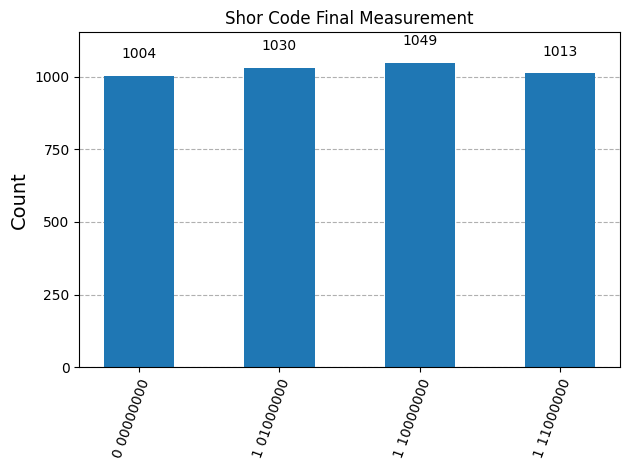

In [93]:
# Simulation
simulator = AerSimulator()
shots = 4096
t_qc_shor = transpile(qc_shor, simulator)
result = simulator.run(t_qc_shor, shots=shots).result()
counts = result.get_counts()

plot_histogram(counts, title="Shor Code Final Measurement")

# 4. The Steane (Quantum Hamming) Code

The Quantum Analog of the Hamming code is the Steane code which is a [[7,1,3]] code that encodes 1 logical qubit into 7 physical qubits and can correct any single-qubit error. It belongs to the family of CSS codes, which are constructed from two classical linear codes.

It is a stabilizer code defined by 6 stabilizer generators:

1. **Z-type** (detect X errors): $Z_0​Z_4​Z_5​Z_6​, Z_1​Z_4​Z_6​Z_7​, Z_2​Z_5​Z_6​Z_7$​

2. **X-type** (detect Z errors): $X_0​X_4​X_5​X_6​, X_1​X_4​X_6​X_7​, X_2​X_5​X_6​X_7​$

In [94]:
# Define Registers
q_s = QuantumRegister(7, name='data')
a_s = QuantumRegister(3, name='ancilla') # 3 ancillas are sufficient
c_s_syn = ClassicalRegister(6, name='syndrome')
c_s_out = ClassicalRegister(1, name='output')
qc_steane = QuantumCircuit(q_s, a_s, c_s_syn, c_s_out)

In [95]:
# Encoding for logical |0>
encoder_0 = QuantumCircuit(q_s, name='Encoder_for_0')
encoder_0.cx(0, 6); encoder_0.cx(1, 6)
encoder_0.cx(2, 5); encoder_0.cx(0, 5)
encoder_0.cx(1, 4); encoder_0.cx(2, 4)
encoder_0.cx(0, 3); encoder_0.cx(1, 3); encoder_0.cx(2, 3)
qc_steane.append(encoder_0, q_s)
qc_steane.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=10, num_clbits=0, params=[]), qubits=(<Qubit register=(7, "data"), index=0>, <Qubit register=(7, "data"), index=1>, <Qubit register=(7, "data"), index=2>, <Qubit register=(7, "data"), index=3>, <Qubit register=(7, "data"), index=4>, <Qubit register=(7, "data"), index=5>, <Qubit register=(7, "data"), index=6>, <Qubit register=(3, "ancilla"), index=0>, <Qubit register=(3, "ancilla"), index=1>, <Qubit register=(3, "ancilla"), index=2>), clbits=())

In [96]:
# Noisy Channel
qc_steane = add_pauli_noise(qc_steane, 0.1, 0.1)
qc_steane.y(q_s[2])
qc_steane.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=10, num_clbits=0, params=[]), qubits=(<Qubit register=(7, "data"), index=0>, <Qubit register=(7, "data"), index=1>, <Qubit register=(7, "data"), index=2>, <Qubit register=(7, "data"), index=3>, <Qubit register=(7, "data"), index=4>, <Qubit register=(7, "data"), index=5>, <Qubit register=(7, "data"), index=6>, <Qubit register=(3, "ancilla"), index=0>, <Qubit register=(3, "ancilla"), index=1>, <Qubit register=(3, "ancilla"), index=2>), clbits=())

In [97]:
# Syndrome Detection
stabilizer_checks = [
    # Z-type stabilizers:
    ([0, 4, 5, 6], 0), ([1, 4, 6, 7-1], 1), ([2, 5, 6, 7-1], 2),
    # X-type stabilizers:
    ([0, 4, 5, 6], 3), ([1, 4, 6, 7-1], 4), ([2, 5, 6, 7-1], 5)
]

for qubits, cbit_idx in stabilizer_checks:
    # Use H gates for Z-type stabilizers
    if cbit_idx < 3: qc_steane.h(a_s[0])
    for q_idx in qubits:
        qc_steane.cx(q_s[q_idx], a_s[0])
    if cbit_idx < 3: qc_steane.h(a_s[0])
    qc_steane.measure(a_s[0], c_s_syn[cbit_idx])
    qc_steane.reset(a_s[0]) # Reset ancilla for next check
qc_steane.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=10, num_clbits=0, params=[]), qubits=(<Qubit register=(7, "data"), index=0>, <Qubit register=(7, "data"), index=1>, <Qubit register=(7, "data"), index=2>, <Qubit register=(7, "data"), index=3>, <Qubit register=(7, "data"), index=4>, <Qubit register=(7, "data"), index=5>, <Qubit register=(7, "data"), index=6>, <Qubit register=(3, "ancilla"), index=0>, <Qubit register=(3, "ancilla"), index=1>, <Qubit register=(3, "ancilla"), index=2>), clbits=())

In [98]:
# 4. Correction

syndrome_map = {1: 0, 2: 1, 3: 3, 4: 2, 5: 5, 6: 4, 7: 6}

for i in range(1, 8):
    x_syndrome = i
    z_syndrome = i << 3
    qubit_to_fix = syndrome_map[i]

    # Y error (both X and Z syndromes trigger)
    with qc_steane.if_test((c_s_syn, x_syndrome | z_syndrome)):
        qc_steane.y(q_s[qubit_to_fix])
    # X error (only X syndrome triggers)
    with qc_steane.if_test((c_s_syn, x_syndrome)) as else_block:
        pass # Placeholder for Qiskit's if/else structure
    with else_block:
        with qc_steane.if_test((c_s_syn, x_syndrome)):
            qc_steane.x(q_s[qubit_to_fix])
    # Z error (only Z syndrome triggers)
    with qc_steane.if_test((c_s_syn, z_syndrome)) as else_block:
        pass
    with else_block:
        with qc_steane.if_test((c_s_syn, z_syndrome)):
             qc_steane.z(q_s[qubit_to_fix])
qc_steane.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=10, num_clbits=0, params=[]), qubits=(<Qubit register=(7, "data"), index=0>, <Qubit register=(7, "data"), index=1>, <Qubit register=(7, "data"), index=2>, <Qubit register=(7, "data"), index=3>, <Qubit register=(7, "data"), index=4>, <Qubit register=(7, "data"), index=5>, <Qubit register=(7, "data"), index=6>, <Qubit register=(3, "ancilla"), index=0>, <Qubit register=(3, "ancilla"), index=1>, <Qubit register=(3, "ancilla"), index=2>), clbits=())

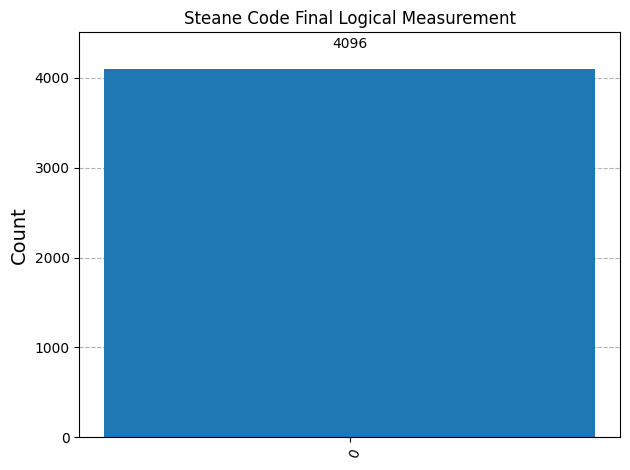

In [99]:
# Decoding and Measurement
decoder = encoder_0.inverse()
qc_steane.append(decoder, q_s)
qc_steane.measure(q_s[0], c_s_out[0]) # THE FIX: No final Hadamards

# Simulation
simulator = AerSimulator()
shots = 4096
t_qc_steane = transpile(qc_steane, simulator)
result_s = simulator.run(t_qc_steane, shots=shots).result()
counts_s = result_s.get_counts()

# Process counts to show only the logical qubit result
logical_counts = {}
for output, count in counts_s.items():
    logical_qubit_result = output.split(' ')[0]
    logical_counts[logical_qubit_result] = logical_counts.get(logical_qubit_result, 0) + count

plot_histogram(logical_counts, title="Steane Code Final Logical Measurement")

# 5. Differences between Shor and Hamming Codes

|Feature|Shor Code [[9,1,3]]|Steane Code [[7,1,3]]|
|  ---  |     ---           |      ---            |
|**Qubit Overhead**|High (9:1). It uses 9 physical qubits for 1 logical qubit.|More Efficient (7:1). It uses only 7 physical qubits for the same task.|
|**Code Structure**|Concatenated Code. <br/> <br/> Its structure is intuitive: a bit-flip code nested inside a phase-flip code.|CSS Code (Calderbank-Shor-Steane). <br/> <br/> It is constructed from two classical linear codes (the Hamming code and its dual). |
|**Syndrome Measurement**|Measures bit-flip and phase-flip syndromes in separate, sequential stages. <br/> <br/> This can increase the depth of the overall error correction circuit.|Measures syndromes for bit-flips (X errors) and phase-flips (Z errors) in parallel.<br/> <br/> The full 6-bit syndrome pinpoints the error type and location in one step.|
|**Fault Tolerance**|Can be made fault-tolerant, but implementing logical gates like the CNOT <br/> <br/> requires complex, non-trivial sequences of physical gates.|Possesses a transversal CNOT, Hadamard, and Phase gate. This means the logical gate <br/> <br/> can be implemented by simply applying the corresponding physical gate to each of the <br/> <br/> 7 data qubits individually. Simplifies the design of fault-tolerant quantum computers.|


# 6. Challenges Detected

1. **Massive Qubit Overhead:** Needing 7 or 9 high-quality physical qubits just to create a single, usable logical qubit is a significant resource cost on current and near-term quantum devices.

2. **Circuit Complexity and Depth:** The circuits for encoding, and especially for syndrome detection, are complex and deep, involving many CNOT gates. Every additional gate increases the probability of an error occurring during the error correction process itself.

3. **Real-Time Classical Control:** The process is not purely quantum. After a syndrome is measured (a quantum operation), the result must be read by a classical controller. This controller must then perform a rapid look-up to determine the correct feedback operation and apply the corresponding corrective pulse to the qubits. This entire classical feedback loop must be completed much faster than the decoherence time of the qubits.